In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.nddata import Cutout2D
from astropy.io import fits
import glob
from src.pipeline import find_flux
import warnings
import cv2
warnings.filterwarnings("ignore")

In [ ]:
from astropy.io import fits
import numpy as np
from src.analysis import gaussian_weight, wiener_deconvolution
from astropy.wcs import WCS
from scipy.signal import fftconvolve
from scipy.ndimage import map_coordinates

def find_flux(image_path: str, telescope: str, weight_size: float, ra: np.ndarray, dec: np.ndarray, correlated: float = None, psf_path:str = None, catalog_path: str = None, psf_size: float = 25, tilesize:int = None) -> tuple[np.ndarray, float]:
    """Find fluxes in an image at given coordinates using weighted aperture photometry.

    Args:
        path (str): Path to the image file.
        telescope (str): Name of the telescope ("Rubin" or "Euclid").
        weight_size (float): Size of the Gaussian weight function.
        coordinates (np.ndarray): Nx2 array of (ra, dec) coordinates.
        correlated (float, optional): Correlation length for noise estimation. Defaults to None.
        psf_path (str, optional): Path to the PSF file. If None, a PSF will be created from the image. Defaults to None.
        psf_size (float, optional): Size of the PSF to create if psf_path is None. Defaults to 25.
        tilesize (int, optional): Size of tiles for local flux measurement. If None, use full image. Defaults to None.
    Returns:
        np.ndarray: Array of fluxes at the given coordinates.
        float: Estimated noise sigma.
    """
    print('Analyzing image')
    with fits.open(image_path) as hdul:
        hdu = hdul[1 if telescope == "Rubin" else 0]
    image = hdu.data
    wcs = WCS(hdu.header)
    nx = hdu.header["NAXIS1"]
    ny = hdu.header["NAXIS2"]

    try:
        zeropoint = hdu.header['MAGZERO']
        conversion_factor = 10**((8.90 - zeropoint)/2.5) * 10**9
    except:
        conversion_factor = 1
    image *= conversion_factor
    

    x, y = wcs.wcs_world2pix(ra, dec, 0, ra_dec_order=True)
    mask = (x >= 0) & (x < nx) & (y >= 0) & (y < ny)
    x[~mask] = None
    y[~mask] = None

    if telescope == 'Rubin':
        intrinsic_weight = gaussian_weight(nx, ny, nx//2, ny//2, weight_size/2, weight_size/2)
        if psf_path is not None:
            with fits.open(psf_path) as hdul:
                psf = hdul[0].data
        else:
            print('Creating PSF')
            catalog = Table.read(catalog_path, format='ascii')
            psf = create_psf(image, catalog_path, psf_size)
        
        print('Deconvolving weight function')
        weight = wiener_deconvolution(intrinsic_weight, psf)
        flux_map = fftconvolve(image, weight[::-1, ::-1], mode='same')
        measured_fluxes = map_coordinates(flux_map, [y, x], order=1)
        if correlated is not None:
            sigma = find_correlated_sigma(image, correlated)
        else:
            negative_pixels = image[image<0].flatten()
            sigma = np.sqrt(np.sum(negative_pixels ** 2) * np.sum(weight ** 2) / len(negative_pixels))
    else:
        if psf_path is not None:
            with fits.open(psf_path) as hdul:
                psf = hdul[0].data
        else:
            print('Creating PSF')
            catalog = Table.read(catalog_path, format='fits', hdu=2)
            psf = create_psf(image, catalog, psf_size)
        
        x_edges = np.arange(0, nx + 1, tilesize)
        y_edges = np.arange(0, ny + 1, tilesize)

        measured_fluxes = np.full(len(x), np.nan)
        sigma_tiles = []       # collect per-tile sigmas
        weight = None
        for y_start, y_end in zip(y_edges[:-1], y_edges[1:]):
            for x_start, x_end in zip(x_edges[:-1], x_edges[1:]):
                print(f"Processing x=({x_start},{x_end}), y=({y_start},{y_end})           ", end='\r', flush=True)
                image_cut = image[y_start:y_end, x_start:x_end]
                if weight is None:
                    intrinsic_weight = gaussian_weight(
                    image_cut.shape[0],
                    image_cut.shape[1],
                    image_cut.shape[0] / 2,
                    image_cut.shape[1] / 2,
                    weight_size,
                    weight_size
                    )
                    weight = wiener_deconvolution(intrinsic_weight, psf)
                # Convolve local tile with full reversed weight
                flux_tile = fftconvolve(image_cut, weight[::-1, ::-1], mode='same')

                # Points inside this tile
                mask_tile = (
                    (x >= x_start) & (x < x_end) &
                    (y >= y_start) & (y < y_end)
                    )
                idx_tile = np.where(mask_tile)[0]
                if len(idx_tile) == 0:
                    continue

                # Local tile coordinates
                xt = x[idx_tile] - x_start
                yt = y[idx_tile] - y_start

                # Flux sampling
                measured_fluxes[idx_tile] = map_coordinates(flux_tile, [yt, xt], order=1)

                # Per-tile sigma
                if correlated is not None:
                    sigma_local = find_correlated_sigma(image_cut, correlated)
                else:
                    neg = image_cut[image_cut < 0].ravel()
                    sigma_local = np.sqrt(
                        np.sum(neg**2) * np.sum(weight**2) / len(neg)
                    )

                sigma_tiles.append(sigma_local)

        # Final sigma = mean over tiles
        sigma = np.mean(sigma_tiles)
    print()
    return measured_fluxes, sigma



In [ ]:
location = '/net/vdesk/data2/deklerk/GAAP_data'
field = '53.0_-28.0'

In [31]:
catalog = Table.read(f'{location}/{field}/VIS.cat', format='fits', hdu=2)
files = glob.glob(f'{location}/{field}/VIS_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[0]
reference_wcs = WCS(hdu.header)
ra_reference, dec_reference = reference_wcs.wcs_pix2world(catalog['X_IMAGE'], catalog['Y_IMAGE'], 0, ra_dec_order=True)

In [96]:
fluxes = {}
sigmas = {}
rubin_filters = ['u', 'g', 'r', 'i', 'y', 'z']
euclid_filters = ['VIS', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']

rubin_filters = []
for filter in rubin_filters:
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")][0]
    psf_file = [file for file in files if file.endswith("psf.fits")][0]
    fluxes[filter], sigmas[filter] = find_flux(image_file, "Rubin", 8, ra_reference, dec_reference, psf_path=psf_file)

euclid_filters = ['DES-G', 'DES-R', 'DES-I']
for filter in euclid_filters:
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")][0]
    fluxes[filter], sigmas[filter] = find_flux(image_file, "Euclid", 8, ra_reference, dec_reference, catalog_path=f'{location}/{field}/{filter}.cat', tilesize = 1200)

Analyzing image
Creating PSF
Analyzing image8000,19200), y=(18000,19200)           
Creating PSF
Analyzing image8000,19200), y=(18000,19200)           
Creating PSF


In [25]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits') as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

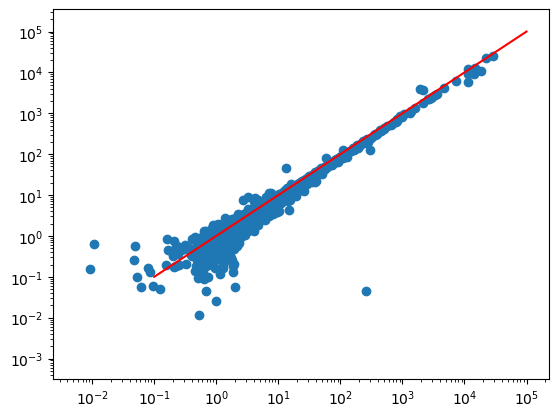

In [95]:
plt.scatter(fluxes['g'], fluxes['DES-G']*4)
plt.plot([1e-1, 1e5], [1e-1, 1e5], c='r')
plt.loglog()
plt.show()

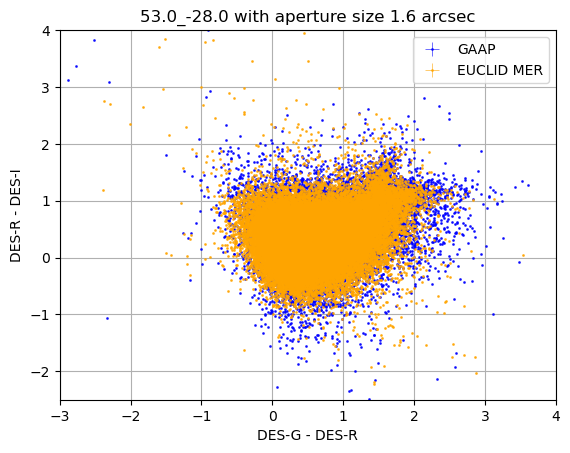

In [103]:
filter_1 = 'DES-G'   # e.g., master_table column name
filter_2 = 'DES-R'
filter_3 = 'DES-R'
filter_4 = 'DES-I'

plot_error = False

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_1] / fluxes[filter_1])**2 +
        (sigmas[filter_2] / fluxes[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_3] / fluxes[filter_3])**2 +
        (sigmas[filter_4] / fluxes[filter_4])**2
    )

    # Optional: filter points with very large errors
    mask = (xerr**2 + yerr**2 < 0.5) & (catalog['CLASS_STAR'] >= 0.0)

    # Plot
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    )
    # plt.title(f'{field} with aperture size {8/5} arcsec')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    x_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    )

    mask = (xerr**2 + yerr**2 < .5)
    
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='EUCLID MER'
    )

    plt.title(f'{field} with aperture size {8/5} arcsec')
    plt.xlabel(f'{filter_1} - {filter_2}')
    plt.ylabel(f'{filter_3} - {filter_4}')
    plt.xlim(-3, 4)
    plt.ylim(-2.5, 4)
    plt.legend()
    plt.show()

In [79]:
def create_psf(image, catalog, psf_size):
    r = 0.1
    percentile_0 = 98
    percentile_1 = 99.9
    increase_window_factor = 2
    x = np.log(catalog['FLUX_RADIUS'])
    y = np.log(catalog['FLUX_AUTO'])
    mask = np.isfinite(x) & np.isfinite(y)
    maximum = -np.inf
    x_0_maximum = -np.inf
    for x_0 in np.linspace(min(x[mask]), max(x[mask]), 100):
        new_mask = np.isfinite(x) & np.isfinite(y) & (x > x_0 - r) & (x < x_0 + r) & (y > 8)
        if np.sum(y[new_mask]) > maximum:
            maximum = np.sum(y[new_mask])
            x_0_maximum = x_0
    # plt.scatter(x[mask], y[mask], color='b', s=1, alpha=0.5)
    selection_mask = np.isfinite(x) & np.isfinite(y) & (x > x_0_maximum - increase_window_factor*r) & (x < x_0_maximum + increase_window_factor*r)
    percentiles = np.percentile(y[selection_mask], [percentile_0, percentile_1])
    selection_mask = np.isfinite(x) & np.isfinite(y) & (x > x_0_maximum - increase_window_factor*r) & (x < x_0_maximum + increase_window_factor*r) & (y > percentiles[0]) & (y < percentiles[1])
    # plt.scatter(x[selection_mask], y[selection_mask], s=1, alpha=0.5, color='r')
    # plt.xlabel('log(flux radius)')
    # plt.ylabel('log flux')
    # plt.show()
    positions = catalog[selection_mask][['X_IMAGE', 'Y_IMAGE']]
    n_cutouts = len(positions)
    cutouts = np.empty((n_cutouts, psf_size, psf_size), dtype=image.dtype)
    for i, (x, y) in enumerate(positions):
        cutout = Cutout2D(image, (x, y), psf_size, mode='partial', fill_value=np.nan)
        cutouts[i] = cutout.data
    psf = np.nanmean(cutouts, axis=0)
    # plt.imshow(psf)
    # plt.show()
    return psf/np.sum(psf)

/var/tmp/deklerk/ipykernel_454617/2526872976.py:22: RuntimeWarning: invalid value encountered in log
  x = np.log(catalog['FLUX_RADIUS'])
/var/tmp/deklerk/ipykernel_454617/2526872976.py:23: RuntimeWarning: invalid value encountered in log
  y = np.log(catalog['FLUX_AUTO'])


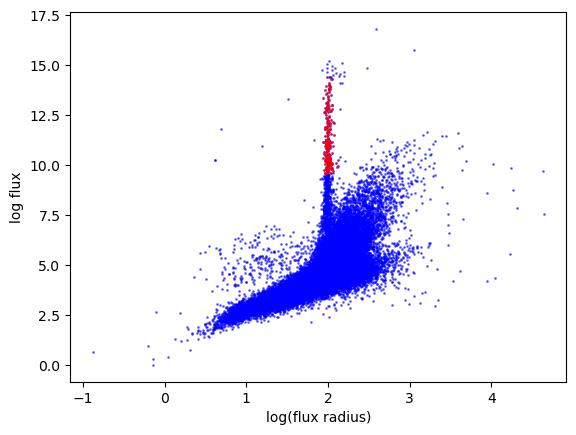

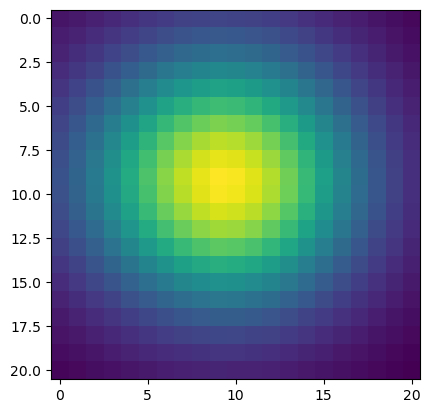

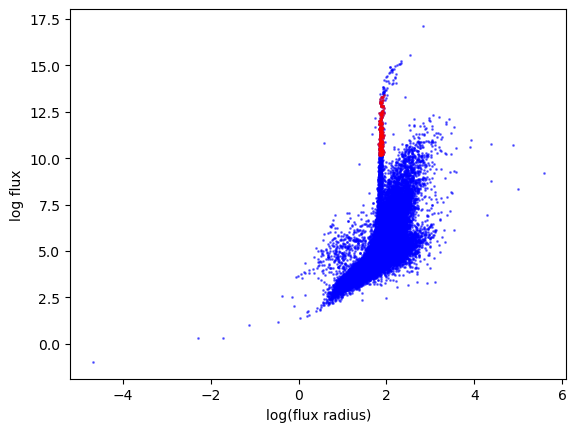

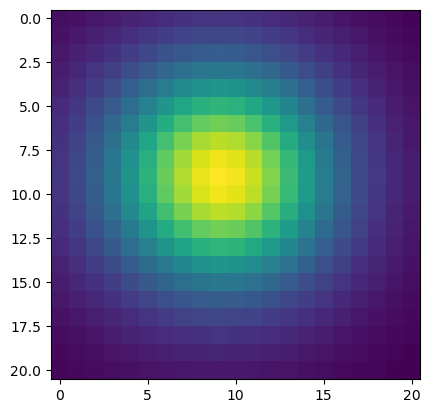

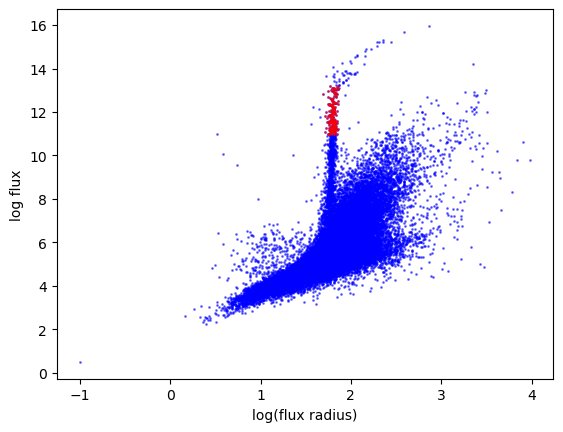

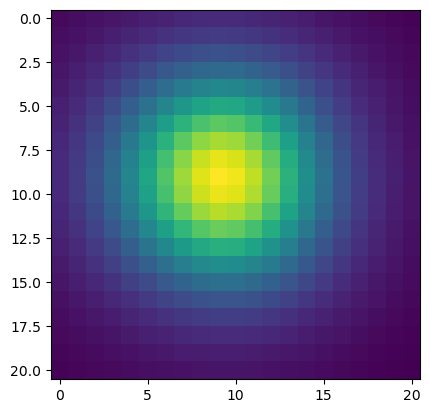

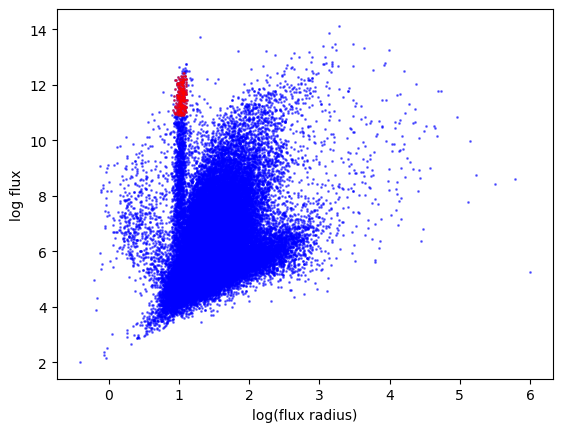

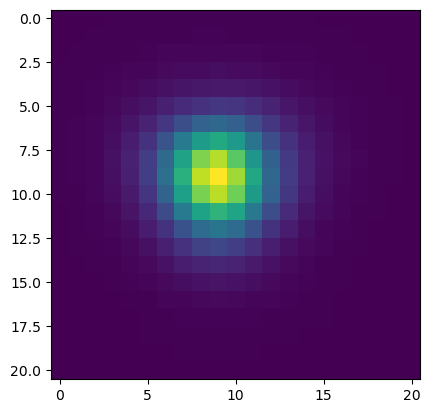

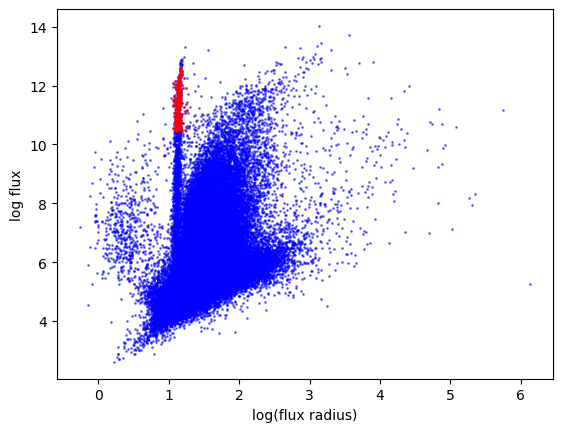

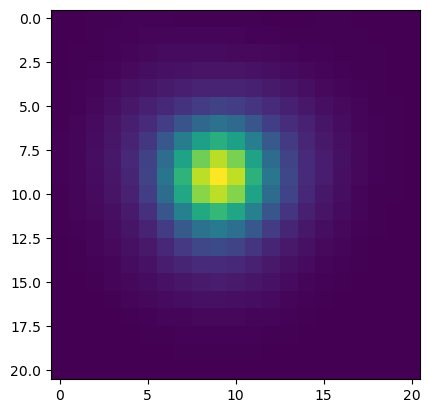

/var/tmp/deklerk/ipykernel_454617/2526872976.py:22: RuntimeWarning: divide by zero encountered in log
  x = np.log(catalog['FLUX_RADIUS'])
/var/tmp/deklerk/ipykernel_454617/2526872976.py:23: RuntimeWarning: divide by zero encountered in log
  y = np.log(catalog['FLUX_AUTO'])


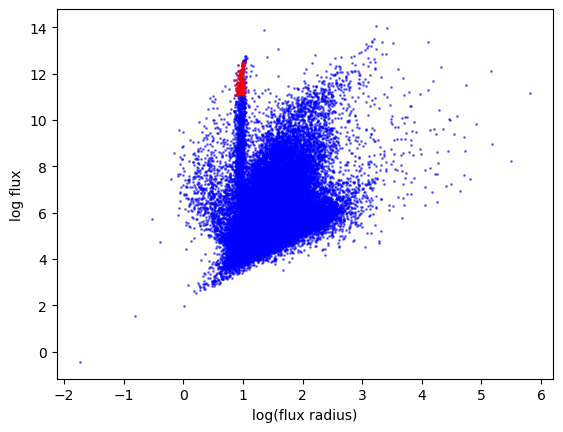

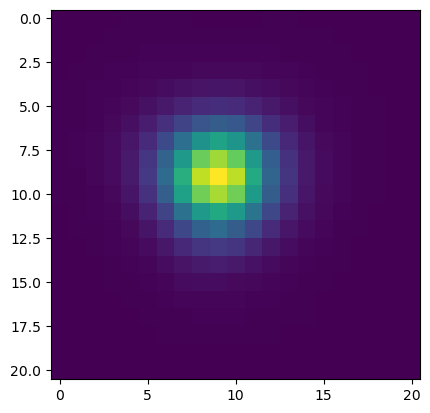

In [ ]:




# Load the image (FITS format)
location = '/net/vdesk/data2/deklerk/GAAP_data'
field = '53.0_-28.0'
r = .05
cutout_size = 21
for filter in ['DES-G', 'DES-R', 'DES-I', 'NIR-J', 'NIR-H', 'NIR-Y']:
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")]
    with fits.open(image_file[0]) as hdul:
        hdu = hdul[0]
        image = hdu.data
    catalog = Table.read(f'{location}/{field}/{filter}.cat', format='fits', hdu=2)
    x = np.log(catalog['FLUX_RADIUS'])
    y = np.log(catalog['FLUX_AUTO'])
    mask = np.isfinite(x) & np.isfinite(y)
    maximum = -np.inf
    x_0_maximum = -np.inf
    for x_0 in np.linspace(min(x[mask]), max(x[mask]), 100):
        new_mask = np.isfinite(x) & np.isfinite(y) & (x > x_0 - r) & (x < x_0 + r) & (y > 8)
        if np.sum(y[new_mask]) > maximum:
            maximum = np.sum(y[new_mask])
            x_0_maximum = x_0
    plt.scatter(x[mask], y[mask], color='b', s=1, alpha=0.5)
    selection_mask = np.isfinite(x) & np.isfinite(y) & (x > x_0_maximum - 2*r) & (x < x_0_maximum + 2*r)
    percentiles = np.percentile(y[selection_mask], [98, 99.9])
    selection_mask = np.isfinite(x) & np.isfinite(y) & (x > x_0_maximum - 2*r) & (x < x_0_maximum + 2*r) & (y > percentiles[0]) & (y < percentiles[1])
    plt.scatter(x[selection_mask], y[selection_mask], s=1, alpha=0.5, color='r')
    plt.xlabel('log(flux radius)')
    plt.ylabel('log flux')
    plt.show()
    positions = catalog[selection_mask][['X_IMAGE', 'Y_IMAGE']]
    n_cutouts = len(positions)
    cutouts = np.empty((n_cutouts, cutout_size, cutout_size), dtype=image.dtype)
    for i, (x, y) in enumerate(positions):
        cutout = Cutout2D(image, (x, y), cutout_size, mode='partial', fill_value=np.nan)
        cutouts[i] = cutout.data
    psf = np.nanmean(cutouts, axis=0)
    plt.imshow(psf)
    plt.show()